**1D-CNN Model tested with MNE dataset**

To see if our model was the reason for poor accuracies, we tried it on an MNE dataset. K fold cross validation was run on with the 1D-CNN model. At the end of the notebook, there is also an experiment with a model taking from the Army Research Laboratory to see how it performs on this dataset compared to our model.

In [ ]:
pip install mne

     |████████████████████████████████| 6.6MB 3.4MB/s 


**Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling2D, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv1D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D, SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from mne import io, pick_types, read_events, Epochs, EvokedArray
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

**Get data**

In [ ]:
data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0.1, 0.3

Using default location ~/mne_data for sample...
Creating ~/mne_data



Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


In [ ]:
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}
# event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}
n_filter = 3

**Read Data**

In [ ]:
# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname, preload=True)
raw.filter(1, 20, fir_design='firwin')
events = read_events(event_fname)

#get eeg channels
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=False,
                picks=picks, baseline=None, preload=True,
                verbose=False)

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 497 samples (3.310 sec)



In [ ]:
# Get the labels and decrement them (to fit confusion matrix / machine learning labels)
labels = epochs.events[:, 2] - 1

[1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 1 2 0
 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 2
 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 3 1
 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0
 3 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2
 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1
 2 0 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3
 1 2 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 2 0 3 1 0 3 1 2 0 3]


**Confusion Matrix Function**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Convert data to 3D array and scale it**

In [ ]:
#array3d = epochs.get_data(picks='eeg')
array3d = epochs.get_data(picks = epochs.ch_names)

#transpose array
array = array3d.swapaxes(1,2)

# Scale data (MAKES A BIG DIFFERENCE IN ACCURACY!!!)
for i in range(array.shape[0]):
    scaler = StandardScaler()
    array[i, :, :] = scaler.fit_transform(array[i, :, :]) 

array.shape

**Create CNN Model**

In [ ]:
#creates 1D-CNN Model
def create_cnn_model():
  #variables to be used for input shape
  # ROWS = 61
  # COLS = 59 

  model = Sequential()
  #add 1D Convolution Layers
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=array[0].shape))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Conv1D(filters=64, kernel_size=5, activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))
  
  model.add(Flatten())
  
  model.add(Dense(64, activation='relu', name='first_dense'))
  model.add(Dense(4, activation='softmax'))

  #compile model
  model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
  
  return model

**K fold experiment with CNN Model**

Train on 230 samples, validate on 58 samples
Epoch 1/15
 - 0s - loss: 1.4292 - accuracy: 0.3261 - val_loss: 1.1846 - val_accuracy: 0.3966
Epoch 2/15
 - 0s - loss: 1.0054 - accuracy: 0.5565 - val_loss: 1.0325 - val_accuracy: 0.4310
Epoch 3/15
 - 0s - loss: 0.8057 - accuracy: 0.6739 - val_loss: 0.9529 - val_accuracy: 0.4483
Epoch 4/15
 - 0s - loss: 0.6302 - accuracy: 0.8043 - val_loss: 0.8417 - val_accuracy: 0.5690
Epoch 5/15
 - 0s - loss: 0.4651 - accuracy: 0.8913 - val_loss: 0.7918 - val_accuracy: 0.6207
Epoch 6/15
 - 0s - loss: 0.3659 - accuracy: 0.9217 - val_loss: 0.8305 - val_accuracy: 0.5690
Epoch 7/15
 - 0s - loss: 0.2938 - accuracy: 0.9130 - val_loss: 0.7618 - val_accuracy: 0.6724
Epoch 8/15
 - 0s - loss: 0.2375 - accuracy: 0.9304 - val_loss: 0.8420 - val_accuracy: 0.5517
Epoch 9/15
 - 0s - loss: 0.1872 - accuracy: 0.9565 - val_loss: 0.7157 - val_accuracy: 0.6379
Epoch 10/15
 - 0s - loss: 0.1314 - accuracy: 0.9870 - val_loss: 0.8415 - val_accuracy: 0.6552
Epoch 11/15
 - 0s - loss

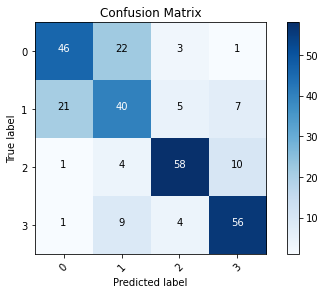

In [ ]:
#1D CNN model
batch_size = 32
n_epochs = 15
n_splits = 5
verbose = 2

class_names = [0, 1, 2, 3]

accuracies = []
losses = []
splits = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(array):
  #split data into X and y training and test sets
  epoch_train, epoch_test = array[train_index], array[test_index]
  label_train, label_test = labels[train_index], labels[test_index]

  #build model
  model = create_cnn_model() 
  
  #fit model
  history = model.fit(epoch_train, label_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(epoch_test, label_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = label_test
  y_pred_prob = model.predict(epoch_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  print(confusion_matrix(y_true, y_pred, labels=class_names))

  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(epoch_test, label_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  splits.append(print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100)))
  split_no += 1

#print final results
for x in range(0, n_splits):
  splits[x]
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Normalized confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
#Plot confusion matrix
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

**Tutorial experiment**

In [ ]:
# Create classification pipeline
clf = make_pipeline(Xdawn(n_components=n_filter),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1', solver='liblinear',
                                       multi_class='auto'))

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

#Classification report
target_names = ['aud_l', 'aud_r', 'vis_l', 'vis_r']
report = classification_report(labels, preds, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 59 from info
    Created an SSP operator (subspace dimension = 1)
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Compu

**Plot Confusion Matrix**

[Text(65.40000000000006, 0.5, 'True label'),
 Text(0.5, -2.510873205539113, 'Predicted label')]

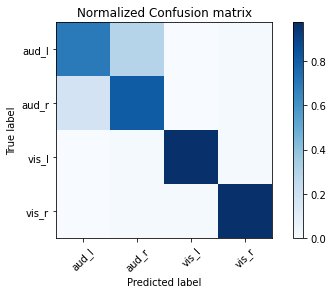

In [ ]:
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')

**Try ARL Model on dataset**

In [ ]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

**K fold**

Epoch 1/15
15/15 - 1s - loss: 1.4665 - sparse_categorical_accuracy: 0.1696 - val_loss: 1.3965 - val_sparse_categorical_accuracy: 0.2069
Epoch 2/15
15/15 - 1s - loss: 1.4400 - sparse_categorical_accuracy: 0.1609 - val_loss: 27567574644755295947829805056.0000 - val_sparse_categorical_accuracy: 0.2069
Epoch 3/15
15/15 - 1s - loss: 1.4591 - sparse_categorical_accuracy: 0.1522 - val_loss: 1156016720688462849084751872.0000 - val_sparse_categorical_accuracy: 0.2759
Epoch 4/15
15/15 - 1s - loss: 1.4512 - sparse_categorical_accuracy: 0.1348 - val_loss: 1.4614 - val_sparse_categorical_accuracy: 0.1724
Epoch 5/15
15/15 - 1s - loss: 1.4478 - sparse_categorical_accuracy: 0.1609 - val_loss: 1.3963 - val_sparse_categorical_accuracy: 0.2069
Epoch 6/15
15/15 - 1s - loss: 1.4490 - sparse_categorical_accuracy: 0.1522 - val_loss: 55969596169400141074564907008.0000 - val_sparse_categorical_accuracy: 0.1897
Epoch 7/15
15/15 - 1s - loss: 1.4356 - sparse_categorical_accuracy: 0.1652 - val_loss: 10956578761290

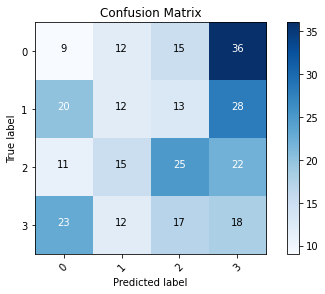

In [ ]:
#static files 
n_epochs = 15
n_splits = 5
batch_size = 16
verbose = 2

class_names = [0, 1, 2, 3]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1
splits = []

#make static trials 4D so it is compatible with Conv2D (trials, rows, channels, 1)
static_4D_trials = np.expand_dims(array, axis=3)

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(static_4D_trials):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_4D_trials[train_index], static_4D_trials[test_index]
  static_y_train, static_y_test = labels[train_index], labels[test_index]

  #build model
  model = EEGNet(nb_classes=4, Chans=61, Samples=59, dropoutRate=0.2, kernLength=5) 
  #compile model
  model.compile(optimizer=keras.optimizers.Adadelta(), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
#plot_metrics(history, 'loss')
#plot_metrics(history, 'accuracy')